# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import time
from datetime import timedelta

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV

In [2]:
def RMSE (trarget_true, target_predict):
    RMSE = mean_squared_error(trarget_true, target_predict, squared=False)
    return RMSE

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# Соберем список столбцов не влияющи на цену автомобиля.
drop_columns = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
# Удалим эти столбцы
df.drop(drop_columns, axis=1, inplace=True)

In [5]:
# Посмотрим на количество пустых ячеек в каждом стобце
print('Количесво строк в датасете: ', df.shape[0])
print(df.isna().sum())

Количесво строк в датасете:  354369
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64


Судя по всему восстановить пропущенные значения мне не удастся по этому будем удалять строки в которых есть хотябы одна пустая ячейка

In [6]:
# Удалим дубл по строкам
df.dropna(axis='index', how='any', inplace=True)

In [7]:
# Узнаем количесво полных дублей и удалим их
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

21054


In [8]:
# Посмотрим какие цифры хранятся в датафрейме
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,224760.000000,224760.000000,224760.000000,224760.000000,224760.000000
mean,5119.025405,2002.873567,119.861964,127254.026517,6.166315
std,4726.035697,6.207929,144.725062,37120.017015,3.480944
min,0.000000,1910.000000,0.000000,5000.000000,0.000000
25%,1490.000000,1999.000000,75.000000,125000.000000,3.000000
50%,3500.000000,2003.000000,110.000000,150000.000000,6.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>],
       [<AxesSubplot:title={'center':'Power'}>,
        <AxesSubplot:title={'center':'Kilometer'}>]], dtype=object)

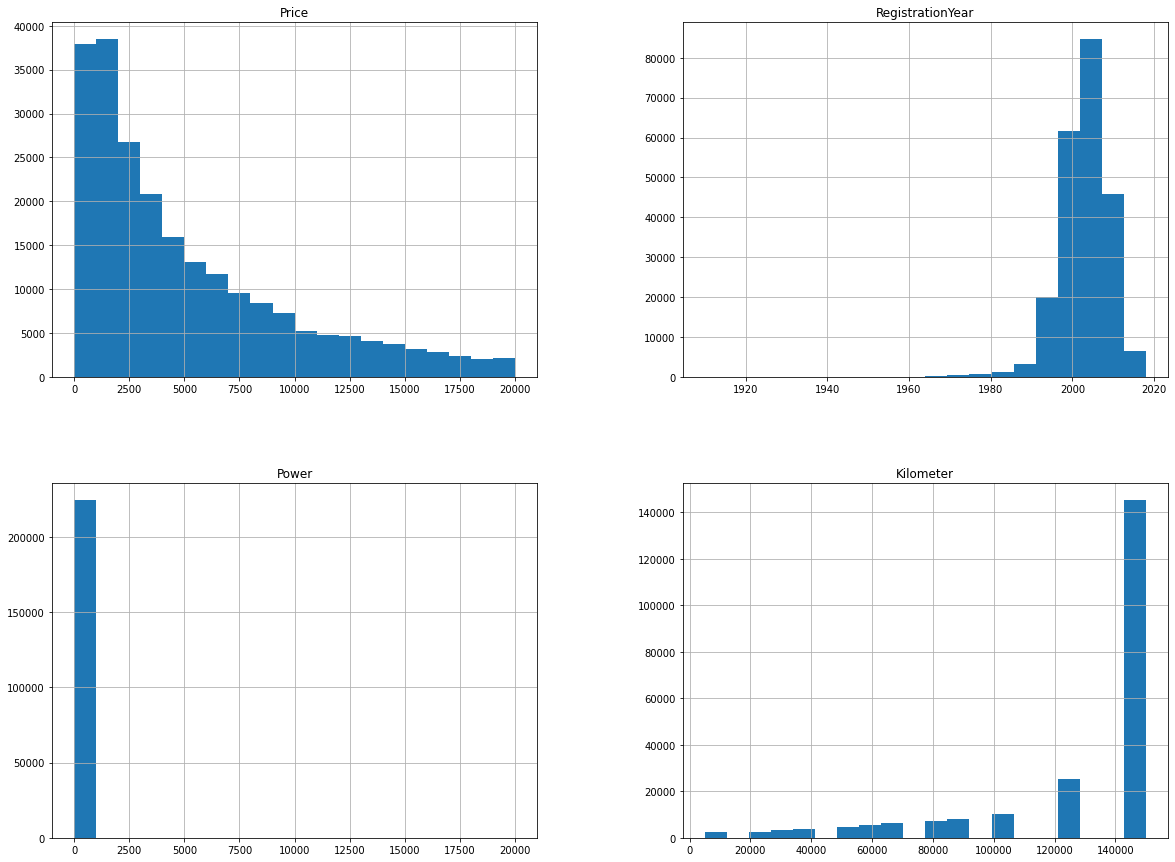

In [9]:
#np.sort(df.Power.unique())
df[['Price', 'RegistrationYear', 'Power', 'Kilometer']].hist(bins=20, figsize=[20,15])

Из всех столбцов не вызвал подозрение только столбец `Kilometer` остальные имеют нулевые значения помотрим подробнее:
- Удалим все строки где в столбце `Price` есть ячеки со значением 0;
- Посмотрим на мощность мощность 0 и 20 000 мне кажутся подозрительными;
- Посмотрим на год регистрации 1910 мне кажется странным.

In [10]:
df[df.Power>2000]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
11039,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no
19092,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no
25232,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no
54607,100,small,1996,manual,3750,polo,125000,4,petrol,volkswagen,yes
56971,1995,wagon,2002,manual,11530,focus,150000,1,petrol,ford,no
64823,10000,wagon,2008,manual,2005,sprinter,150000,1,gasoline,mercedes_benz,no
87830,2550,small,2004,auto,6226,fortwo,125000,5,petrol,smart,no
95569,1000,small,1996,manual,4400,ibiza,90000,9,petrol,seat,yes
100680,3500,sedan,1993,auto,11635,80,125000,2,petrol,audi,no
113184,350,small,1995,manual,5575,polo,150000,1,petrol,volkswagen,yes


In [11]:
# Посмотрим на одну модель 
df.query('Model == "caddy" and Brand == "volkswagen" and VehicleType == "bus" and FuelType == "gasoline" and RegistrationYear == 2009 and Gearbox == "manual"')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
11542,3100,bus,2009,manual,105,caddy,150000,8,gasoline,volkswagen,no
25232,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no
43900,5999,bus,2009,manual,105,caddy,150000,12,gasoline,volkswagen,no
77152,16000,bus,2009,manual,140,caddy,70000,11,gasoline,volkswagen,no
79473,6950,bus,2009,manual,105,caddy,150000,10,gasoline,volkswagen,no
83136,6999,bus,2009,manual,75,caddy,150000,7,gasoline,volkswagen,no
95128,6200,bus,2009,manual,105,caddy,150000,5,gasoline,volkswagen,no
99512,7450,bus,2009,manual,105,caddy,150000,1,gasoline,volkswagen,no
110849,4000,bus,2009,manual,105,caddy,150000,7,gasoline,volkswagen,yes
111758,6900,bus,2009,manual,75,caddy,150000,9,gasoline,volkswagen,no


Судя по всему проще будет удалить все выбросы

In [12]:
#df[df.Power>2000]['Power'].hist(bins=100, figsize=[15,20])
np.sort(df.Power.unique())

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

__Удалим все, что меньше 30 и более 500__

In [13]:
df = df[~((df.Power>500) | (df.Power<30))].copy()

In [14]:
# Посотмрим все даты регистраций автомобиля
np.sort(df.RegistrationYear.unique())

array([1930, 1931, 1937, 1938, 1942, 1943, 1945, 1947, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

Впринципе всё в рамках разумного

<AxesSubplot:>

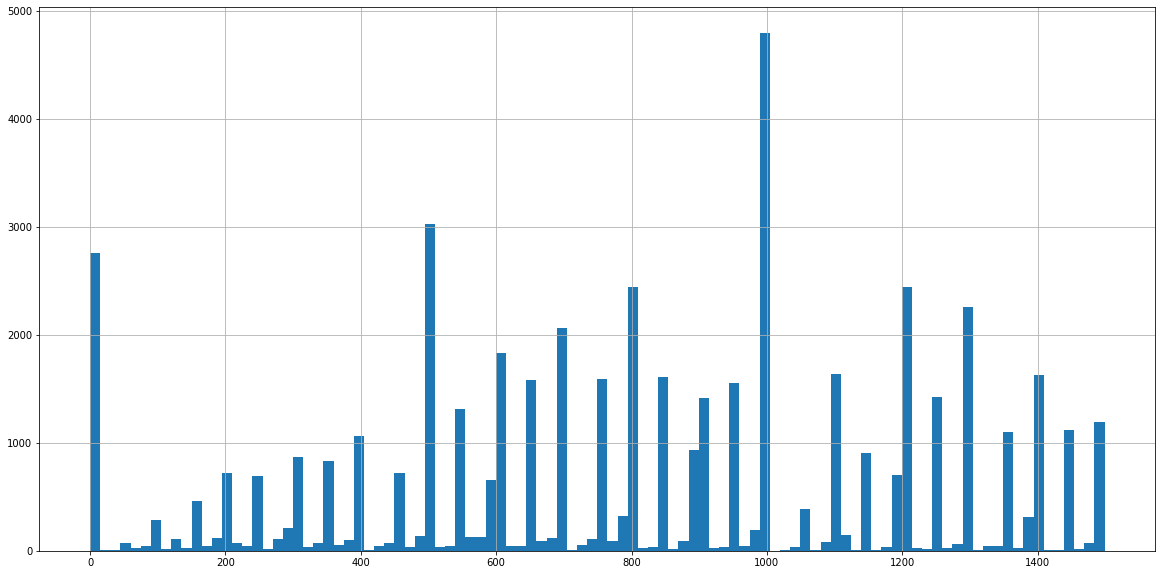

In [15]:
df[df.Price<1500]['Price'].hist(bins=100, figsize=[20,10])

Удалим все цены меньше 100

In [16]:
np.sort(df.RegistrationMonth.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [17]:
# Удалим нулевой месяц
df = df[~(df.RegistrationMonth==0)].copy()

In [18]:
df = df[~(df.Price<100)].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206758 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              206758 non-null  int64 
 1   VehicleType        206758 non-null  object
 2   RegistrationYear   206758 non-null  int64 
 3   Gearbox            206758 non-null  object
 4   Power              206758 non-null  int64 
 5   Model              206758 non-null  object
 6   Kilometer          206758 non-null  int64 
 7   RegistrationMonth  206758 non-null  int64 
 8   FuelType           206758 non-null  object
 9   Brand              206758 non-null  object
 10  NotRepaired        206758 non-null  object
dtypes: int64(5), object(6)
memory usage: 18.9+ MB


In [19]:
# Преобразуем все строковые столбцы в нижний регистр
col = list(df.select_dtypes(include='object').columns)
for c in col:
    df[str(c)] = df[str(c)].str.lower()

In [20]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no


Сильной корреляции не обнаружено.  

## Обучение моделей

In [21]:
df_cat_light = df.copy()
cat_features = col

# Разобьем данные
features = df_cat_light.drop(['Price'], axis=1)
target = df_cat_light['Price']

# По идее можно без этой строки обойтись
features[cat_features] = features[cat_features].astype('category')

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.4, 
                                                                            random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)


### CatBoostRegressor

In [22]:
"""
model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=2,learning_rate=1, depth=2)
model_cbr.fit(features_train, target_train, cat_features)
pred_cbr = model_cbr.predict(features_test)
RMSE(target_valid, pred_cbr)
"""

"\nmodel_cbr = CatBoostRegressor(loss_function='RMSE', iterations=2,learning_rate=1, depth=2)\nmodel_cbr.fit(features_train, target_train, cat_features)\npred_cbr = model_cbr.predict(features_test)\nRMSE(target_valid, pred_cbr)\n"

In [23]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124054 entries, 12621 to 125195
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        124054 non-null  category
 1   RegistrationYear   124054 non-null  int64   
 2   Gearbox            124054 non-null  category
 3   Power              124054 non-null  int64   
 4   Model              124054 non-null  category
 5   Kilometer          124054 non-null  int64   
 6   RegistrationMonth  124054 non-null  int64   
 7   FuelType           124054 non-null  category
 8   Brand              124054 non-null  category
 9   NotRepaired        124054 non-null  category
dtypes: category(6), int64(4)
memory usage: 5.6 MB


In [24]:
model_cbr = CatBoostRegressor()
param_dist = {'learning_rate': np.linspace(0.2, 1, 8),
              'max_depth': [3, 10, 15, 20],
              'iterations':[10,20,30]}

rs_cbr = RandomizedSearchCV(model_cbr, param_dist, 
                            n_iter = 3,
                            cv = 3,
                            verbose = 1,
                            n_jobs=-1,
                            random_state=12345,
                            scoring='neg_root_mean_squared_error')
rs_cbr.fit(features_train, target_train, cat_features = cat_features)
print(rs_cbr.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0:	learn: 2982.0599060	total: 596ms	remaining: 11.3s
1:	learn: 2301.3377765	total: 1.12s	remaining: 10.1s
2:	learn: 1930.5452581	total: 1.7s	remaining: 9.64s
3:	learn: 1774.2800222	total: 2.28s	remaining: 9.11s
4:	learn: 1709.7573885	total: 2.86s	remaining: 8.59s
5:	learn: 1649.8696770	total: 3.41s	remaining: 7.96s
6:	learn: 1611.0285557	total: 3.96s	remaining: 7.35s
7:	learn: 1589.0442161	total: 4.5s	remaining: 6.75s
8:	learn: 1566.6926812	total: 5.06s	remaining: 6.18s
9:	learn: 1539.8008147	total: 5.66s	remaining: 5.66s
10:	learn: 1516.6830430	total: 6.21s	remaining: 5.08s
11:	learn: 1492.4975933	total: 6.79s	remaining: 4.53s
12:	learn: 1479.9161080	total: 7.39s	remaining: 3.98s
13:	learn: 1457.4117890	total: 7.97s	remaining: 3.42s
14:	learn: 1442.4164879	total: 8.53s	remaining: 2.84s
15:	learn: 1419.7541970	total: 9.08s	remaining: 2.27s
16:	learn: 1397.0655402	total: 9.62s	remaining: 1.7s
17:	learn: 1384.1496116	total: 10.2s

__Посмотрим на ошибку и время обучения__

In [25]:
res_rs_cbr = pd.DataFrame(rs_cbr.cv_results_)
res_rs_cbr[['mean_test_score', 'mean_fit_time', 'rank_test_score']].sort_values(by='rank_test_score')

,mean_test_score,mean_fit_time,rank_test_score
0,-1658.879047,11.412487,1
2,-1756.634396,1.132915,2
1,-1951.912917,2.142334,3


### LGBMRegressor

In [26]:
#cat_idx = [features_train.columns.get_loc(c) for c in cat_features]

In [27]:
#eval_set = [(features_train, target_train)]
"""
model_lgbmr = LGBMRegressor()
model_lgbmr.fit(features_train,
                target_train,
                categorical_feature='auto',
                #eval_set=eval_set,
                eval_metric='rmse')
pred_lgbmr = model_lgbmr.predict(features_test)
RMSE(target_test, pred_lgbmr)
"""

"\nmodel_lgbmr = LGBMRegressor()\nmodel_lgbmr.fit(features_train,\n                target_train,\n                categorical_feature='auto',\n                #eval_set=eval_set,\n                eval_metric='rmse')\npred_lgbmr = model_lgbmr.predict(features_test)\nRMSE(target_test, pred_lgbmr)\n"

In [28]:
model_lgbmr = LGBMRegressor()
params_lgbmr = { 
    'learning_rate': np.linspace(start = 0.001, stop = 0.009, num = 10),
    'n_estimators': [int(x) for x in np.linspace(start = 2, stop = 200, num = 10)],
    'num_leaves': [int(x) for x in np.linspace(start = 2, stop = 200, num = 10)], 
    'random_state' : [12345],
    #'num_boost_round' : [3, 1000],
    'colsample_bytree' : [x for x in np.linspace(start = 0.1, stop = 0.9, num = 10)],
    'subsample' : [x for x in np.linspace(start = 0.1, stop = 0.9, num = 10)],
    'reg_alpha' : [x for x in np.linspace(start = 1, stop = 2, num = 10)],
    'reg_lambda' : [x for x in np.linspace(start = 1, stop = 2, num = 10)], 
    }

rs_lgbmr = RandomizedSearchCV(model_lgbmr,
                              params_lgbmr,
                              n_iter = 3,
                              cv = 3,
                              verbose = 1,
                              n_jobs=-1,
                              random_state=12345,
                              scoring='neg_root_mean_squared_error')
rs_lgbmr.fit(features_train, target_train)
rs_lgbmr.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


{'subsample': 0.7222222222222222,
 'reg_lambda': 1.7777777777777777,
 'reg_alpha': 1.5555555555555556,
 'random_state': 12345,
 'num_leaves': 68,
 'n_estimators': 200,
 'learning_rate': 0.009,
 'colsample_bytree': 0.2777777777777778}

__Посмотрим на ошибку и время обучения__

In [29]:
res_rs_lgbmr = pd.DataFrame(rs_lgbmr.cv_results_)
res_rs_lgbmr[['mean_test_score', 'mean_fit_time', 'rank_test_score']].sort_values(by='rank_test_score')

,mean_test_score,mean_fit_time,rank_test_score
2,-2571.203008,6.228327,1
0,-3402.795531,4.200123,2
1,-3640.532007,6.499889,3


### LinearRegression

In [30]:
df_linreg = df.copy()

"""# Преобразуем столбцы в числа
le = LabelEncoder()
for c in col:
    le.fit(df[str(c)])
    df_linreg[str(c)] = le.transform(df_linreg[str(c)])"""

# Применим OHE
l_features = df_linreg.drop(['Price'], axis=1)
l_target = df_linreg['Price']

model_OHE = ColumnTransformer(
    [('OHE', OneHotEncoder(),col)],
    remainder = 'passthrough'
    )
dummified = model_OHE.fit_transform(l_features)
l_features = pd.DataFrame(dummified.toarray())


l_features_train, l_features_test, l_target_train, l_target_test = train_test_split(l_features, 
                                                                                    l_target, 
                                                                                    test_size=0.4, 
                                                                                    random_state=12345)

l_features_test, l_features_valid, l_target_test, l_target_valid = train_test_split(l_features_test,
                                                                                    l_target_test, 
                                                                                    test_size=0.5, 
                                                                                    random_state=12345)
# Нормализуем все численные признаки
scaler = StandardScaler()
scaler.fit(l_features_train)
l_features_train = scaler.transform(l_features_train)
l_features_test = scaler.transform(l_features_test)
l_features_valid = scaler.transform(l_features_valid)

__Посмотрим на ошибку и время обучения__

In [31]:
%%time
lr = LinearRegression()
lr.fit(l_features_train, l_target_train)
pred_lr = lr.predict(l_features_test)
RMSE(l_target_test, pred_lr)

CPU times: user 11.3 s, sys: 4.25 s, total: 15.6 s
Wall time: 15.5 s


2539.764636214629

В итоге выберем лучше параметры моделй и посотрим какая будет быстрее.

## Анализ моделей

In [32]:
#%%time
# CatBoostRegressor
#{'max_depth': 15, 'learning_rate': 0.5428571428571429, 'iterations': 5}
model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=5,learning_rate=0.5428571428571429, max_depth=15)

start_time_cbr = time.monotonic()
#--
model_cbr.fit(features_train, target_train, cat_features)
pred_cbr = model_cbr.predict(features_valid)
#--
end_time_cbr = time.monotonic()
total_time_cbr = end_time_cbr - start_time_cbr
RMSE_cbr = RMSE(target_valid, pred_cbr)
print('CatBoostRegressor')
print('RMSE: ', RMSE_cbr)
print('Time ', total_time_cbr)

0:	learn: 3000.8746984	total: 593ms	remaining: 2.37s
1:	learn: 2315.6115372	total: 1.13s	remaining: 1.7s
2:	learn: 1936.1111609	total: 1.67s	remaining: 1.11s
3:	learn: 1775.3128073	total: 2.18s	remaining: 546ms
4:	learn: 1710.2905235	total: 2.69s	remaining: 0us
CatBoostRegressor
RMSE:  1761.5935179768355
Time  3.568291130941361


In [33]:
#%%time

# LGBMRegressor
{'subsample': 0.7222222222222222,
 'reg_lambda': 1.7777777777777777,
 'reg_alpha': 1.5555555555555556,
 'random_state': 12345,
 'num_leaves': 68,
 'n_estimators': 200,
 'learning_rate': 0.009,
 'colsample_bytree': 0.2777777777777778}

model_lgbmr = LGBMRegressor(subsample=0.72, 
                            reg_lambda=1.8,
                            reg_alpha=1.6,
                            random_state=12345,
                            num_leaves=68,
                            n_estimators=200,
                            learning_rate=0.009,
                            colsample_bytree=0.28
                           )
start_time_lgbmr = time.monotonic()

#--
model_lgbmr.fit(features_train,
                target_train,
                categorical_feature='auto',
                #eval_set=eval_set,
                eval_metric='rmse')
pred_lgbmr = model_lgbmr.predict(features_valid)
#--

end_time_lgbmr = time.monotonic()
total_time_lgbmr = end_time_lgbmr - start_time_lgbmr
RMSE_lgbmr = RMSE(target_valid, pred_lgbmr)

print('LGBMRegressor')
print('RMSE: ', RMSE_lgbmr)
print('Time ', total_time_lgbmr)

LGBMRegressor
RMSE:  2564.7850435528053
Time  10.323463150300086


In [34]:
#%%time

lr = LinearRegression()

start_time_lr = time.monotonic()
#--
lr.fit(l_features_train, l_target_train)
pred_lr = lr.predict(l_features_valid)
#--
end_time_lr = time.monotonic()
total_time_lr = end_time_lr - start_time_lr

RMSE_lr = RMSE(target_valid, pred_lr)

print('LinearRegression')
print('RMSE: ', RMSE_lr)
print('Time ', total_time_lr)

LinearRegression
RMSE:  2490.0084621829546
Time  12.69954365491867


__Посмотрим на скорость выполнения моделей и RMSE в одном месте__

In [35]:
tem_RMSE_model = {'Name model': ['CatBoostRegressor', 'LGBMRegressor', 'LinearRegression'], 
                  'RMSE': [RMSE_cbr, RMSE_lgbmr, RMSE_lr],
                  'Time': [total_time_cbr, total_time_lgbmr, total_time_lr]
                 }
a_table = pd.DataFrame(tem_RMSE_model)
a_table

,Name model,RMSE,Time
0,CatBoostRegressor,1761.593518,3.568291
1,LGBMRegressor,2564.785044,10.323463
2,LinearRegression,2490.008462,12.699544


__Вывод:__

И тут безоговорочным победителем стала модель `CatBoostRegressor` с минимальной ошибкой и наименьшим временем выполнения.   
С показателями:  
RMSE = `1714.337471` и `Time = 3.701492`